In [41]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [42]:
#Load Dataset and process it
train = pd.read_csv('data/cleaned_mostRecStat_train.csv',header=0,encoding='iso-8859-1')
train_y = train['is_placed']
train = train.drop("is_placed",1)


test = pd.read_csv('data/cleaned_mostRecStat_test.csv',header=0,encoding='iso-8859-1')
test_y = test['is_placed']
test = test.drop("is_placed",1)

print ("Features are : ", train.columns)
train = train.fillna(0.0)
test = test.fillna(0.0)
print ("Dataset Target count: \n", train_y.value_counts())

Features are :  Index(['in_process', 'client_id', 'is_rockstar', 'consulting', 'permanent',
       'source_id', 'willingToRelocate', 'is_gmail', 'is_aol', 'is_custom',
       ...
       'tech_8', 'tech_9', 'tech_total', 'main_1', 'main_16', 'main_2',
       'main_3', 'main_4', 'main_5', 'main_total'],
      dtype='object', length=112)
Dataset Target count: 
 0    14529
1      134
Name: is_placed, dtype: int64


In [43]:
#Modeling is done here
#Import relevant module for modelling.
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix,roc_auc_score

def testTrees(X_train,y_train,X_test,y_test,dep,leaf):
    clf = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=leaf,max_depth=dep)
    clf = clf.fit(X_train,y_train)
    cm = confusion_matrix(clf.predict(X_test),y_test)
    accuracy = (cm[0][0]+cm[1][1])/float(len(X_test))
    misclass_rate = 1 - accuracy
    #print "Depth: %d, Leaf: %d, Misclassification Rate: %f, Accuracy: %f" %(dep,leaf,misclass_rate,accuracy)
    return roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]), misclass_rate


In [44]:
depths=np.arange(1,6,1)
leaves=np.arange(1,100,1)
target = []
#Run all of the options
run=1
if (run==1):
    #Initialize dictionary of results
    res=dict()
    res2=dict()
    for d in depths:
        res[d]=list()
        res2[d]=list()

    #Now train and get results for each option
    for d in depths:
        for l in leaves:
            roc,mis = testTrees(train,train_y,test,test_y,d,l)
            res[d].append(roc)
            res2[d].append(mis)

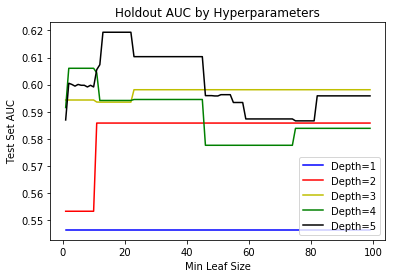

In [45]:
#Plot Result           
fig = plt.figure()
ax=fig.add_subplot(111)
for i in np.arange(0,len(depths), 5):
    plt.plot(leaves,res[depths[i]],'b-',label='Depth={}'.format(depths[i]))
    plt.plot(leaves,res[depths[i+1]],'r-',label='Depth={}'.format(depths[i+1]))
    plt.plot(leaves,res[depths[i+2]],'y-',label='Depth={}'.format(depths[i+2]))
    plt.plot(leaves,res[depths[i+3]],'g-',label='Depth={}'.format(depths[i+3]))
    plt.plot(leaves,res[depths[i+4]],'k-',label='Depth={}'.format(depths[i+4]))
plt.legend(loc=4)
ax.set_xlabel('Min Leaf Size')
ax.set_ylabel('Test Set AUC')
plt.title('Holdout AUC by Hyperparameters')

In [46]:
erate = 999
dep = 0
leaf_size = 0
for d in depths:
    print ("Smallest error rate in depth %d is %f, leaf size is %d"%(d,min(res2[d]),leaves[np.argmin(res2[d])]))
    if min(res2[d]) < erate:
        erate = min(res2[d])
        dep = d
        leaf_size = leaves[np.argmin(res2[d])]

Smallest error rate in depth 1 is 0.010344, leaf size is 1
Smallest error rate in depth 2 is 0.010344, leaf size is 1
Smallest error rate in depth 3 is 0.010344, leaf size is 1
Smallest error rate in depth 4 is 0.010344, leaf size is 1
Smallest error rate in depth 5 is 0.010344, leaf size is 1


Optimal Depth: 1, Leaf Size: 1

Top 20 feature importance

is_rockstar 0.214787214939
source_id 0.182106012464
in_process 0.180814481446
client_id 0.088279556858
tech_total 0.0775930952688
func_30 0.0711728386951
is_citizen 0.0651393308585
func_33 0.04770652585
tech_22 0.0421321983094
main_1 0.0302687453115
func_42 0.0
func_31 0.0
func_24 0.0
func_25 0.0
func_26 0.0
func_27 0.0
func_28 0.0
func_29 0.0
func_3 0.0
func_49 0.0


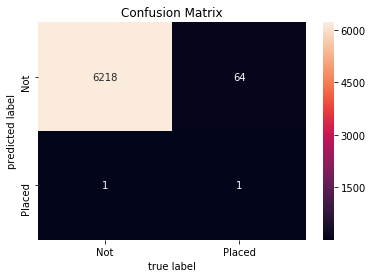

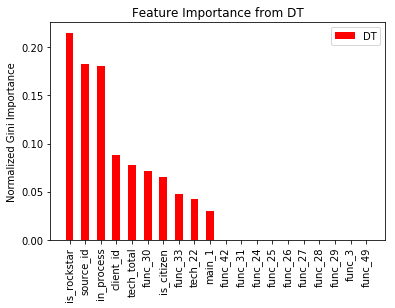

In [47]:

target_names = ['Not','Placed']
print ("Optimal Depth: %d, Leaf Size: %d"%(dep,leaf_size))
clf = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=leaf_size,max_depth=d)
clf = clf.fit(train,train_y)
cm = confusion_matrix(clf.predict(test),test_y)
cm = pd.DataFrame(cm, columns=target_names, index=target_names)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Confusion Matrix')

#Feature analysis
dt_features = clf.feature_importances_
cols = train.columns.values
fig, ax = plt.subplots()
width=0.5

sorted_index= np.argsort(dt_features)
topn = list(sorted_index[-20:])
topn.reverse()
print ("\nTop 20 feature importance\n")
for i in topn:
    print (cols[i], dt_features[i])
    
ax.bar(np.arange(len(cols[topn])), dt_features[topn], width, color='r', label='DT')
ax.set_xticks(np.arange(len(cols[topn])))
ax.set_xticklabels(cols[topn], rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')
plt.legend(loc=1)

In [48]:
from sklearn import tree
tree.export_graphviz(clf, out_file='tree.dot')  

In [49]:
print (cm)


         Not  Placed
Not     6218      64
Placed     1       1
